In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # UserWarning 억제
warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarning 억제

# 심볼 목록 정의
crypto_symbols = ["BTC-USD","BCH-USD", "SOL-USD", "XRP-USD",  "APT21794-USD","ARB11841-USD","AVAX-USD","COTI-USD", "CRV-USD", "EOS-USD","ETC-USD","ETH-USD","FET-USD",
                  "FTM-USD","GALA-USD", "LDO-USD", "LINK-USD","LTC-USD","NEAR-USD", "ONDO-USD","SAND-USD","SEI-USD", "UNI7083-USD", "WLD-USD"]

# 현재 날짜와 시간 가져오기
now = datetime.now()
current_hour = now.replace(minute=0, second=0, microsecond=0)  # 현재 시각의 시 만큼 자르고 더 작은 단위는 0으로 설정

# 데이터 가져오기
crypto_data = yf.download(crypto_symbols, start=current_hour - timedelta(days=30), end=current_hour, interval="1h").fillna(method='ffill')

# Close 가격만 선택
close_prices = crypto_data['Close']

# 오늘 포함된 데이터 확인
print(close_prices.tail(2))

[*********************100%***********************]  24 of 24 completed


Ticker                     APT21794-USD  ARB11841-USD   AVAX-USD     BCH-USD  \
Datetime                                                                       
2024-12-06 06:00:00+00:00      14.26494      1.167652  53.406815  597.423584   
2024-12-06 07:00:00+00:00      14.26494      1.167652  53.399529  597.388062   

Ticker                         BTC-USD  COTI-USD   CRV-USD   EOS-USD  \
Datetime                                                               
2024-12-06 06:00:00+00:00  98088.15625  0.182253  1.098494  1.374640   
2024-12-06 07:00:00+00:00  98134.53125  0.182248  1.098340  1.374628   

Ticker                       ETC-USD      ETH-USD  ...   LINK-USD     LTC-USD  \
Datetime                                           ...                          
2024-12-06 06:00:00+00:00  36.647991  3910.353271  ...  24.016386  136.500320   
2024-12-06 07:00:00+00:00  36.645630  3909.473145  ...  24.016977  136.491776   

Ticker                     NEAR-USD  ONDO-USD  SAND-USD   SEI-USD

In [9]:
# 일반 수익률 계산
returns = crypto_data['Close'].pct_change(fill_method=None).dropna()  # 결측치를 채우지 않음

# 변동성 계산 함수
def calculate_volatility(data, window):
    return data.rolling(window=window).std()

# 각 주기에 대한 변동성 계산
volatility_1h = returns.std() * np.sqrt(1)  # 1시간 변동성
volatility_12h = returns.resample('12h').std().mean() * np.sqrt(12)  # 4시간 변동성
volatility_1D = returns.resample('D').std().mean() * np.sqrt(24)  # 일간 변동성
volatility_3D = returns.resample('3D').std().mean() * np.sqrt(24 * 3)  # 주간 변동성

# 포트폴리오 기대 수익률 (평균으로 설정)
portfolio_return = returns.mean()

# 샤프 지수 계산 (일간 기반)
sharpe_1D = (portfolio_return * 24 - 0) / volatility_1D  # 일간 샤프 비율


# 결과를 데이터프레임으로 정리
volatility_df = pd.DataFrame({
    '1H': (volatility_1h * 100).round(1),
    '12H': (volatility_12h * 100).round(1),
    '1D': (volatility_1D * 100).round(1),
    '3D': (volatility_3D * 100).round(1),
    'Sharpe': sharpe_1D.round(2),
})

# Daily 기준으로 내림차순 정렬
volatility_df_sorted = volatility_df.sort_values(by='1D')

# 결과 출력
print(volatility_df_sorted)

               1H  12H   1D    3D  Sharpe
Ticker                                   
BTC-USD       0.6  1.8  2.6   4.7    0.38
ETH-USD       0.8  2.5  3.6   6.4    0.40
SOL-USD       0.9  3.1  4.4   7.9    0.22
BCH-USD       1.3  4.1  6.0  10.2    0.30
AVAX-USD      1.3  4.3  6.2  10.9    0.42
LINK-USD      1.4  4.3  6.2  11.0    0.42
LTC-USD       1.4  4.3  6.2  10.9    0.40
ETC-USD       1.3  4.4  6.3  10.9    0.38
APT21794-USD  1.4  4.5  6.5  11.3    0.26
ARB11841-USD  1.4  4.7  6.8  12.0    0.43
UNI7083-USD   1.5  4.8  6.9  12.7    0.33
NEAR-USD      1.4  4.8  6.9  12.2    0.35
EOS-USD       1.6  5.0  7.2  12.4    0.56
FET-USD       1.5  5.0  7.2  12.8    0.23
ONDO-USD      1.6  5.2  7.5  12.8    0.45
SEI-USD       1.6  5.3  7.6  12.9    0.31
FTM-USD       1.7  5.5  7.9  13.8    0.34
COTI-USD      1.7  5.4  7.9  14.3    0.33
LDO-USD       1.7  5.4  7.9  13.8    0.32
GALA-USD      1.7  5.6  8.0  14.0    0.49
WLD-USD       1.8  5.9  8.5  15.4    0.34
XRP-USD       2.0  6.0  8.6  14.9 

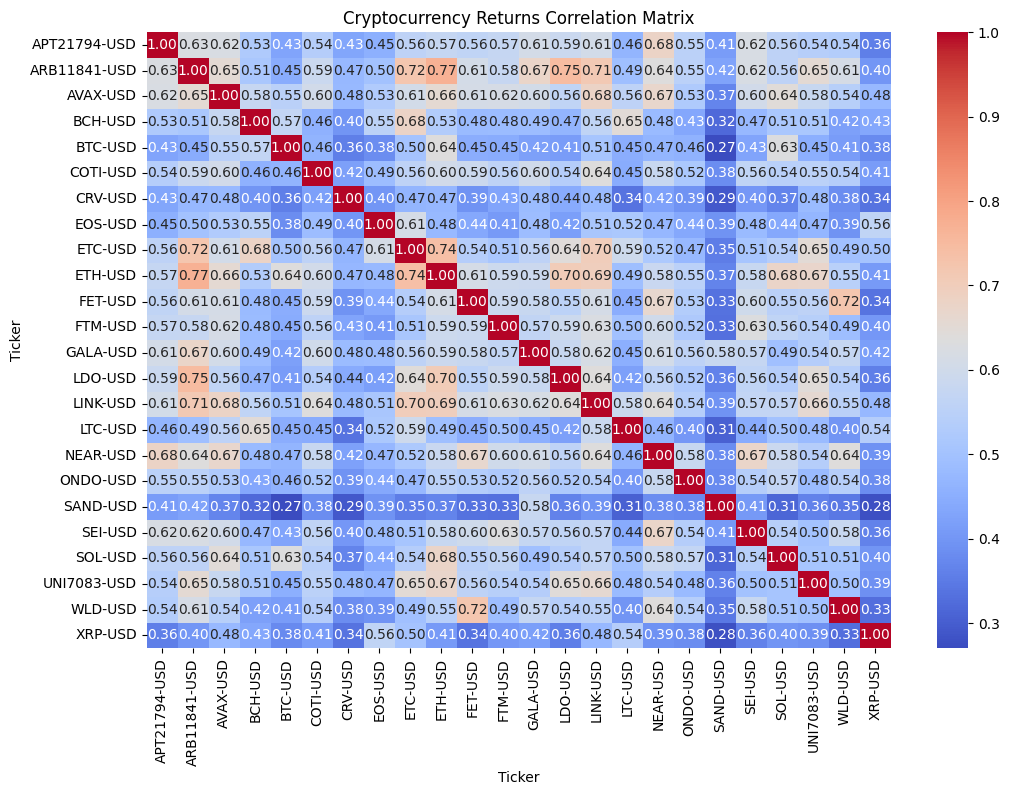

In [10]:
# 상관관계 계산
correlation_matrix = returns.corr()

# 상관관계 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Cryptocurrency Returns Correlation Matrix')
plt.show()

In [11]:
### 최근 종가 가져오기
recent_close_prices = crypto_data['Close'].iloc[-1]  # 최신 종가

# recent_close_prices['BONK-USD'] = recent_close_prices['BONK-USD'] * 1000

# 변동성을 기준으로 가격 계산
Down_prices_1D = recent_close_prices * (1 - (volatility_1D))  # 12시간 변동성 적용
Down_prices_3D = recent_close_prices * (1 - (volatility_3D))  # 일간 변동성 적용
Up_prices_1D = recent_close_prices * (1 + (volatility_1D))  # 일간 변동성 적용
Up_prices_3D = recent_close_prices * (1 + (volatility_3D))  # 일간 변동성 적용


# 결과를 새로운 데이터프레임으로 정리
adjusted_prices_df = pd.DataFrame({
    'Down Price (1D)': Down_prices_1D.round(4),
    'Down Price (3D)': Down_prices_3D.round(4),
    'Up Price (1D)': Up_prices_1D.round(4),
    'Up Price (3D)': Up_prices_3D.round(4)
})
# 결과 출력
print("\nAdjusted Prices DataFrame:")
print(adjusted_prices_df)


Adjusted Prices DataFrame:
              Down Price (1D)  Down Price (3D)  Up Price (1D)  Up Price (3D)
Ticker                                                                      
APT21794-USD          13.3346          12.6464        15.1953        15.8835
ARB11841-USD           1.0884           1.0272         1.2469         1.3081
AVAX-USD              50.0903          47.5743        56.7087        59.2248
BCH-USD              561.6809         536.3539       633.0952       658.4223
BTC-USD            95537.2218       93535.0133    100731.8407    102734.0492
COTI-USD               0.1679           0.1562         0.1966         0.2083
CRV-USD                1.0021           0.9231         1.1946         1.2736
EOS-USD                1.2755           1.2038         1.4738         1.5455
ETC-USD               34.3521          32.6355        38.9392        40.6558
ETH-USD             3768.7121        3659.6382      4050.2342      4159.3081
FET-USD                1.9196           1.8029  

In [12]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 각 암호화폐의 수량 입력 받기
quantities = ({
  "BTC-USD": 000,
  "BCH-USD": 3,
  "SOL-USD": 000,
  "APT21794-USD": 00,
  "ARB11841-USD": 800,
  "AVAX-USD": 30,
  "COTI-USD": 6000,
  "CRV-USD": 2500,
  "EOS-USD": 00,
  "ETC-USD": 30,
  "ETH-USD": 0.5,
  "FET-USD": 500,
  "FTM-USD": 750,
  "GALA-USD": 00000,
  "LDO-USD": 800,
  "LINK-USD": 000,
  "LTC-USD": 10,
  "NEAR-USD": 150,
  "ONDO-USD": 000,
  "SAND-USD": 000,
  "SEI-USD": 0000,
  "UNI7083-USD":100,
  "XRP-USD": 0000,
  "WLD-USD": 500,


})

# 현재 가격 가져오기
latest_prices = crypto_data['Close'].iloc[-1]

# 포트폴리오의 각 암호화폐의 현재 가치를 계산
portfolio_value = sum(latest_prices[symbol] * quantities[symbol] for symbol in quantities.keys())

# 포트폴리오 비중 계산
weights = {symbol: (latest_prices[symbol] * quantities[symbol]) / portfolio_value for symbol in quantities.keys()}

# Pandas Series로 변환
weights = pd.Series(weights)

crypto_symbols = list(weights.index)

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility_hourly = np.sqrt(portfolio_variance)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 동안의 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)
var_95_daily = -z_score * portfolio_volatility_daily * portfolio_value  # 포트폴리오 가치

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")
print(f"95% VaR (daily, value): ${var_95_daily:,.2f} ({var_95_daily/portfolio_value:.2%})")
print(f"Portfolio_Value: {portfolio_value:,.2f}")

Daily Portfolio Volatility: 5.52%
Daily Portfolio Mean: 3.12%
95% VaR (daily, value): $1,925.77 (9.09%)
Portfolio_Value: 21,195.02


In [13]:
# 각 코인별 VaR 계산 및 출력
individual_vars = []  # 각 코인별 VaR를 저장할 리스트

for symbol in crypto_symbols:
    weight = weights[symbol]
    if weight > 0:  # 롱 포지션이 있는 경우에만 VaR 계산
        individual_mean = returns[symbol].mean() * 24  # 일간 기대 수익률
        individual_volatility = returns[symbol].std() * np.sqrt(24)  # 일간 변동성

        individual_var_dollar = weight * (-z_score * individual_volatility * portfolio_value)  # 금액 손실
        individual_var_percent = (individual_var_dollar / portfolio_value) * 100  # 퍼센트 손실

        print(f"{symbol} : ${individual_var_dollar:.2f} ({individual_var_percent:.2f}%)")
        individual_vars.append(individual_var_dollar)  # VaR를 리스트에 추가

# 95% VaR의 총합 계산 및 출력
total_var_95 = sum(individual_vars)
print(f"\nTotal 95% VaR (daily, value): ${total_var_95:.2f}")

BCH-USD : $191.79 (0.90%)
ARB11841-USD : $108.28 (0.51%)
AVAX-USD : $172.78 (0.82%)
COTI-USD : $149.21 (0.70%)
CRV-USD : $429.06 (2.02%)
ETC-USD : $118.67 (0.56%)
ETH-USD : $120.73 (0.57%)
FET-USD : $125.45 (0.59%)
FTM-USD : $136.74 (0.65%)
LDO-USD : $238.04 (1.12%)
LTC-USD : $156.40 (0.74%)
NEAR-USD : $137.74 (0.65%)
UNI7083-USD : $191.07 (0.90%)
WLD-USD : $293.60 (1.39%)

Total 95% VaR (daily, value): $2569.57


In [14]:
# 공분산 행렬 계산
cov_matrix = returns.cov()
mean_returns = returns.mean()

# 코인 그룹 나누기 (예시) - 실제 코인 목록에 맞춰 수정해야 합니다.
first_group = ["BTC-USD","BCH-USD", "SOL-USD","XRP-USD", "ETH-USD"]
second_group = ["APT21794-USD","ARB11841-USD", "AVAX-USD","COTI-USD", "CRV-USD", "EOS-USD", "ETC-USD", "FET-USD",
               "FTM-USD","GALA-USD","LDO-USD","LTC-USD","LINK-USD","NEAR-USD", "ONDO-USD","SAND-USD", "SEI-USD", "UNI7083-USD", "WLD-USD"]

# crypto_symbols 리스트 중복 제거
crypto_symbols = list(set(first_group + second_group))

crypto_symbols = first_group + second_group

# first_group와 second_group에 해당하는 인덱스 얻기
first_indices = [crypto_symbols.index(symbol) for symbol in first_group]
second_indices = [crypto_symbols.index(symbol) for symbol in second_group]


# 최소 변동성과 최대 샤프 비율 최적화 함수 (수정)
def optimize_portfolio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio # 샤프 비율 최대화를 위해 - 부호를 제거

# 초기 비중 설정
num_assets = len(crypto_symbols)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# 제약 조건 (수정)
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 전체 비중 1
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[first_indices]) - 0.8},  # FIRST 그룹 비중 80%
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[second_indices]) - 0.2}  # SECOND 그룹 비중 20%
)
bounds = tuple((0, 1) for asset in range(num_assets))

# 최적화 실행 및 결과 출력 (기존 코드 동일)
optimized_results = minimize(optimize_portfolio, initial_weights, method='trust-constr', bounds=bounds, constraints=constraints, options={'maxiter':1000}) #maxiter 추가


# 최적화된 비중
optimal_weights = optimized_results.x
optimal_weights=pd.Series(optimized_results.x, index=crypto_symbols) # index 추가
optimal_weights = optimal_weights.sort_values(ascending=False)

optimal_return = np.dot(optimal_weights, mean_returns) * 24
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(24)
optimal_sharpe = optimal_return / optimal_volatility

print("Optimal Portfolio:")
for i, weight in enumerate(optimal_weights.round(3)):
    print(f"{optimal_weights.index[i]}: {weight:.1%}") #index 사용

print(f"\nExpected Daily Return: {optimal_return:.2%}")
print(f"Daily Volatility: {optimal_volatility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")

Optimal Portfolio:
BCH-USD: 17.5%
ETH-USD: 17.1%
SOL-USD: 16.9%
XRP-USD: 15.0%
BTC-USD: 13.6%
WLD-USD: 1.3%
ARB11841-USD: 1.3%
NEAR-USD: 1.2%
AVAX-USD: 1.2%
FET-USD: 1.1%
LINK-USD: 1.1%
LDO-USD: 1.0%
GALA-USD: 1.0%
UNI7083-USD: 1.0%
COTI-USD: 1.0%
CRV-USD: 1.0%
ETC-USD: 1.0%
LTC-USD: 1.0%
SEI-USD: 1.0%
APT21794-USD: 1.0%
FTM-USD: 1.0%
ONDO-USD: 1.0%
SAND-USD: 0.9%
EOS-USD: 0.9%

Expected Daily Return: 2.24%
Daily Volatility: 5.00%
Sharpe Ratio: 0.45
